# NLP Pipeline Example 

SPAM messages from [UCI](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

In [1]:
import pandas as pd

messages = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Some info:

In [2]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Basic Feature Engineering

In [4]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


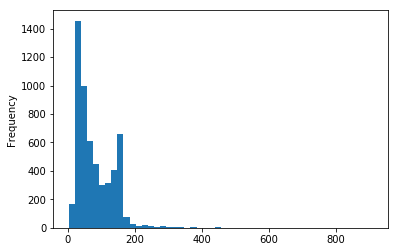

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
messages['length'].plot(bins=50, kind='hist')

Train-test:

In [7]:
from sklearn.cross_validation import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

print('Train_size:', len(msg_train), 'Test_size:', len(msg_test))

Train_size: 4457 Test_size: 1115


### Pipeline time!

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('bow', TfidfVectorizer(ngram_range = (2,4))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', GradientBoostingClassifier(n_estimators=400)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [9]:
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)

In [10]:
from sklearn.metrics import classification_report

print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1026
       spam       0.66      0.99      0.79        89

avg / total       0.97      0.96      0.96      1115



In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve((label_test == 'spam')*1, (predictions == 'spam')*1)
auc(fpr, tpr)

0.8303179026997228

### Pipeline com GridSearchCV:

In [90]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('clf', GradientBoostingClassifier(n_estimators=400)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 
              'tfidf__use_idf': (True, False),
              'clf__n_estimators': (200, 400, 800),}


gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, scoring='roc_auc')
gs_clf = gs_clf.fit(msg_train, label_train)

In [92]:
gs_clf.best_score_

0.9782364819385236

In [93]:
gs_clf.best_params_

{'clf__n_estimators': 800,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2)}

In [94]:
preds = gs_clf.predict(msg_test)
print(classification_report(preds, label_test)) 

             precision    recall  f1-score   support

        ham       1.00      0.98      0.99       993
       spam       0.84      1.00      0.91       122

avg / total       0.98      0.98      0.98      1115



In [95]:
fpr, tpr, thresholds = roc_curve((label_test == 'spam')*1, (preds == 'spam')*1)
auc(fpr, tpr)

0.9206896551724137

### Keras time!

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [28]:
vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(msg_train)
sequences = tokenizer.texts_to_sequences(msg_train)
test_sequence_ = tokenizer.texts_to_sequences(msg_test)
data = pad_sequences(sequences, maxlen=50)
data_test = pad_sequences(test_sequence_, maxlen=50)

In [29]:
model = Sequential()
model.add(Embedding(10000, 100, input_length=50))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
model.fit(x=data, y=(label_train == 'ham')*1, validation_data=(data_test, (label_test == 'ham')*1), epochs = 3)

Train on 4457 samples, validate on 1115 samples
Epoch 1/3
4457/4457 [==============================] - 9s 2ms/step - loss: 0.1708 - acc: 0.9462 - val_loss: 0.0534 - val_acc: 0.9839
Epoch 2/3
4457/4457 [==============================] - 7s 2ms/step - loss: 0.0296 - acc: 0.9924 - val_loss: 0.0474 - val_acc: 0.9830
Epoch 3/3
4457/4457 [==============================] - 7s 2ms/step - loss: 0.0116 - acc: 0.9964 - val_loss: 0.0455 - val_acc: 0.9857


In [39]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(data_test)
roc_auc_score((label_test == 'ham')*1, y_pred)

0.9954838709677419

**Trying to use 1D convolution also:**

In [40]:
model_conv = Sequential()
model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model_conv.fit(x=data, y=(label_train == 'ham')*1, validation_data=(data_test, (label_test == 'ham')*1), epochs = 3)

Train on 4457 samples, validate on 1115 samples
Epoch 1/3
4457/4457 [==============================] - 6s 1ms/step - loss: 0.1904 - acc: 0.9309 - val_loss: 0.0808 - val_acc: 0.9767
Epoch 2/3
4457/4457 [==============================] - 5s 1ms/step - loss: 0.0330 - acc: 0.9908 - val_loss: 0.0854 - val_acc: 0.9785
Epoch 3/3
4457/4457 [==============================] - 5s 1ms/step - loss: 0.0118 - acc: 0.9973 - val_loss: 0.0612 - val_acc: 0.9839


In [42]:
from sklearn.metrics import roc_auc_score

y_pred = model_conv.predict_proba(data_test)
roc_auc_score((label_test == 'ham')*1, y_pred)

0.9911861559139785